# TSP Route Planner & Visualizer

# Dataset Info:
This project uses a dataset of 50 major cities in Pakistan.
Each city entry contains its name, latitude, and longitude.
Data Source: Manually compiled city coordinates
File used: pakistan_cities_coordinates.csv

The dataset is used to compute Euclidean distances between cities and
simulate real-world route planning using TSP algorithms.

In [31]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import itertools
import time

# Step 1: Load CSV and prepare city data
# Load the dataset and preview the top rows to verify structure and content #

In [32]:
df = pd.read_csv("pakistan_cities_coordinates.csv")
print("\nDataset Preview:")
print(df.head())
print("\nTotal Cities Loaded:", len(df))
cities = df.to_dict(orient='records')


Dataset Preview:
         City  Latitude  Longitude
0     Karachi   24.8607    67.0011
1      Lahore   31.5497    74.3436
2  Faisalabad   31.4504    73.1350
3  Rawalpindi   33.6007    73.0679
4      Multan   30.1575    71.5249

Total Cities Loaded: 51


# Data validation: drop rows with missing or malformed coordinates

In [33]:
df = pd.read_csv("pakistan_cities_coordinates.csv")
print("\nDataset Preview:")
print(df.head())
print("\nTotal Cities Loaded:", len(df))


Dataset Preview:
         City  Latitude  Longitude
0     Karachi   24.8607    67.0011
1      Lahore   31.5497    74.3436
2  Faisalabad   31.4504    73.1350
3  Rawalpindi   33.6007    73.0679
4      Multan   30.1575    71.5249

Total Cities Loaded: 51


# Optional Feature: Filter only a subset (e.g., first 8 cities) for Brute Force
# This is used to avoid performance issues with factorial time complexity of brute-force

In [34]:
df.dropna(subset=['Latitude', 'Longitude', 'City'], inplace=True)
df = df[df['Latitude'].apply(lambda x: isinstance(x, (int, float))) & df['Longitude'].apply(lambda x: isinstance(x, (int, float)))]
cities = df.to_dict(orient='records')

In [35]:
# Optional Feature: Filter only a subset (e.g., first 8 cities) for Brute Force
# This is used to avoid performance issues with factorial time complexity of brute-force
subset_cities = cities[:8]
print("Subset Cities for Brute Force:", [c['City'] for c in subset_cities])

Subset Cities for Brute Force: ['Karachi', 'Lahore', 'Faisalabad', 'Rawalpindi', 'Multan', 'Peshawar', 'Islamabad', 'Quetta']


# Step 2: Define distance calculation and matrix builder

In [36]:
def euclidean_distance(city1, city2):
    return math.hypot(city1["Longitude"] - city2["Longitude"], city1["Latitude"] - city2["Latitude"])

def build_distance_matrix(cities):
    n = len(cities)
    matrix = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            matrix[i][j] = euclidean_distance(cities[i], cities[j])
    return matrix

# Step 3: Nearest Neighbor TSP Algorithm

In [37]:
def nearest_neighbor(matrix, start=0):
    n = len(matrix)
    visited = [False]*n
    path = [start]
    visited[start] = True
    total_cost = 0
    current = start

    for _ in range(n - 1):
        next_city = min(
            [(i, matrix[current][i]) for i in range(n) if not visited[i]],
            key=lambda x: x[1]
        )[0]
        total_cost += matrix[current][next_city]
        path.append(next_city)
        visited[next_city] = True
        current = next_city

    total_cost += matrix[current][start]
    path.append(start)
    return path, total_cost

# Step 4: Brute Force TSP Algorithm (only for small N)

In [38]:
def brute_force_tsp(matrix):
    n = len(matrix)
    cities = list(range(n))
    min_cost = float('inf')
    best_path = []
    for perm in itertools.permutations(cities[1:]):
        current_path = [0] + list(perm) + [0]
        cost = sum(matrix[current_path[i]][current_path[i+1]] for i in range(n))
        if cost < min_cost:
            min_cost = cost
            best_path = current_path
    return best_path, min_cost

In [39]:
# Step 4B: Held-Karp TSP Algorithm (Dynamic Programming)
def held_karp(matrix):
    n = len(matrix)
    C = {}

    for k in range(1, n):
        C[(1 << k, k)] = (matrix[0][k], [0, k])

    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            bits = 0
            for bit in subset:
                bits |= 1 << bit

            for k in subset:
                prev = bits & ~(1 << k)
                res = []
                for m in subset:
                    if m == k:
                        continue
                    res.append((C[(prev, m)][0] + matrix[m][k], C[(prev, m)][1] + [k]))
                C[(bits, k)] = min(res)

    bits = (2 ** n - 1) - 1
    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + matrix[k][0], C[(bits, k)][1] + [0]))
    cost, path = min(res)
    return path, cost
    n = len(matrix)
    cities = list(range(n))
    min_cost = float('inf')
    best_path = []
    for perm in itertools.permutations(cities[1:]):
        current_path = [0] + list(perm) + [0]
        cost = sum(matrix[current_path[i]][current_path[i+1]] for i in range(n))
        if cost < min_cost:
            min_cost = cost
            best_path = current_path
    return best_path, min_cost

# Step 5: Visualize the path using matplotlib

In [40]:
# Step 5: Visualize the path using matplotlib
from mpl_toolkits.mplot3d import Axes3D
def plot_tsp_path(cities, path, algorithm_name, cost):
    # 2D Visualizer
    x = [cities[i]['Longitude'] for i in path]
    y = [cities[i]['Latitude'] for i in path]
    labels = [cities[i]['City'] for i in path]

    plt.figure(figsize=(12, 8))
    plt.plot(x, y, 'o-', markersize=8)
    for i, label in enumerate(labels):
        plt.annotate(f"{i+1}. {label}", (x[i], y[i]), fontsize=9)
    plt.title(f"TSP Path - {algorithm_name} | Cost: {round(cost, 2)}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

# Step 6: Run Nearest Neighbor


Running Nearest Neighbor...
Nearest Neighbor Path Cost: 66.92
Time: 0.0004 seconds


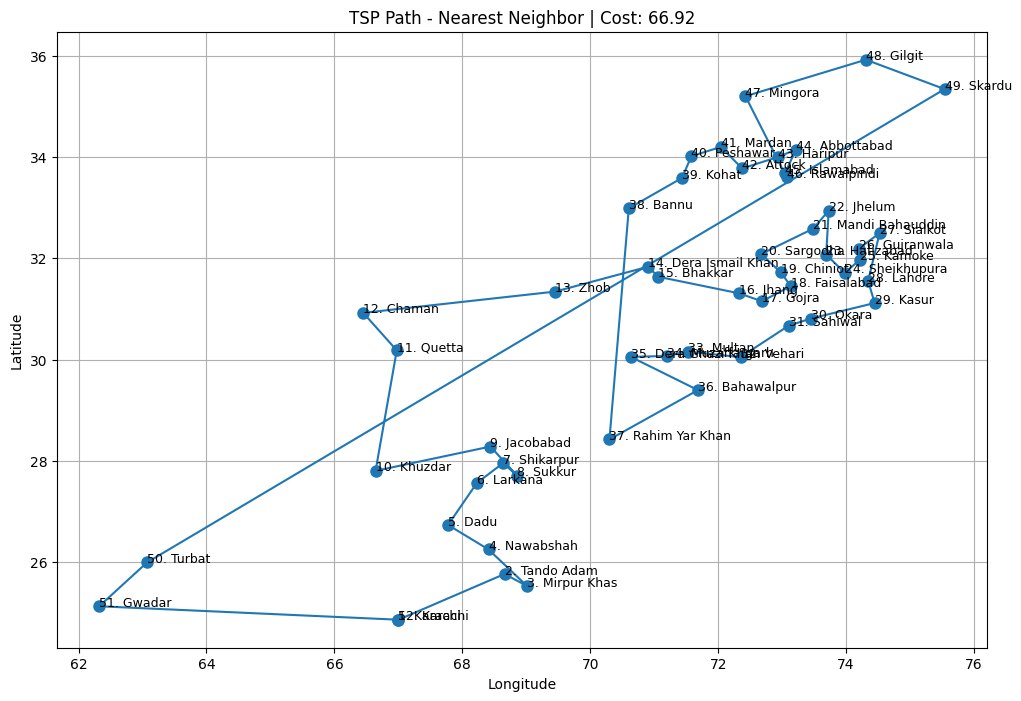

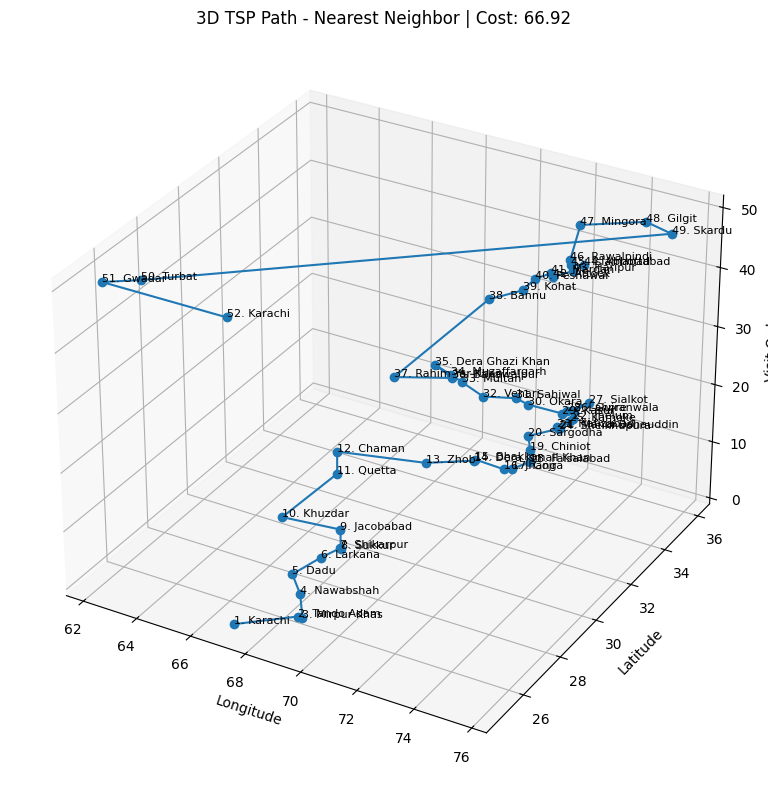

In [41]:
print("\nRunning Nearest Neighbor...")
matrix_nn = build_distance_matrix(cities)
start_time = time.time()
path_nn, cost_nn = nearest_neighbor(matrix_nn)
elapsed_nn = time.time() - start_time
print("Nearest Neighbor Path Cost:", round(cost_nn, 2))
print("Time:", round(elapsed_nn, 4), "seconds")
plot_tsp_path(cities, path_nn, "Nearest Neighbor", cost_nn)
plot_tsp_path_3d(cities, path_nn, "Nearest Neighbor", cost_nn)

In [44]:
# 3D Visualizer for TSP Path

def plot_tsp_path_3d(cities, path, algorithm_name, cost):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x = [cities[i]['Longitude'] for i in path]
    y = [cities[i]['Latitude'] for i in path]
    z = list(range(len(path)))

    ax.plot(x, y, z, marker='o')
    for i, city_idx in enumerate(path):
        ax.text(x[i], y[i], z[i], f"{i+1}. {cities[city_idx]['City']}", size=8)

    ax.set_title(f"3D TSP Path - {algorithm_name} | Cost: {round(cost, 2)}")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Visit Order')
    plt.tight_layout()
    plt.show()

In [49]:
# Step 8B: Comparison Chart for Algorithms

def plot_comparison_chart(results):
    names = [r["name"] for r in results]
    costs = [r["cost"] for r in results]
    times = [r["time"] for r in results]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    ax1.bar(names, costs, color='skyblue', label='Path Cost')
    ax2.plot(names, times, color='orange', marker='o', label='Execution Time (s)')

    ax1.set_ylabel('Path Cost')
    ax2.set_ylabel('Execution Time (seconds)')
    ax1.set_title("TSP Algorithm Comparison")
    ax1.grid(True)

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Step 7: Run Brute Force on Subset

In [50]:
print("\nRunning Brute Force (on 8 cities)...")
matrix_bf = build_distance_matrix(subset_cities)
start_time = time.time()
path_bf, cost_bf = brute_force_tsp(matrix_bf)
elapsed_bf = time.time() - start_time
print("Brute Force Path Cost:", round(cost_bf, 2))
print("Time:", round(elapsed_bf, 4), "seconds")


Running Brute Force (on 8 cities)...
Brute Force Path Cost: 25.56
Time: 0.0065 seconds


Running Held-Karp (on 8 cities)...
Held-Karp Path Cost: 25.56
Time: 0.0009 seconds


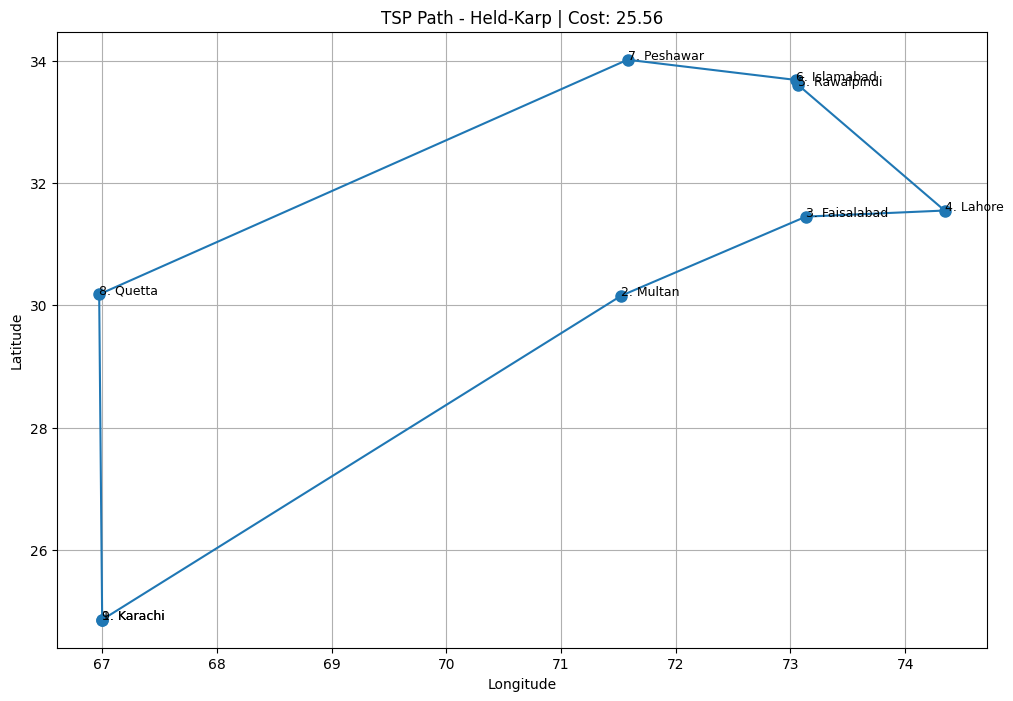

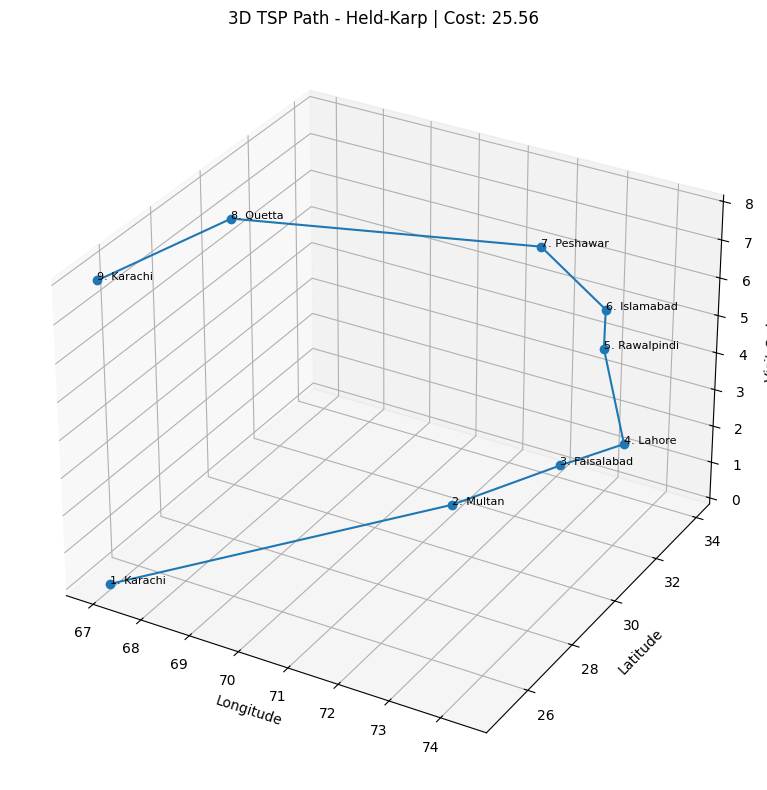

In [51]:
# Step 7B: Run Held-Karp on Subset
print("Running Held-Karp (on 8 cities)...")
start_time = time.time()
path_hk, cost_hk = held_karp(matrix_bf)
elapsed_hk = time.time() - start_time
print("Held-Karp Path Cost:", round(cost_hk, 2))
print("Time:", round(elapsed_hk, 4), "seconds")
plot_tsp_path(subset_cities, path_hk, "Held-Karp", cost_hk)
plot_tsp_path_3d(subset_cities, path_hk, "Held-Karp", cost_hk)

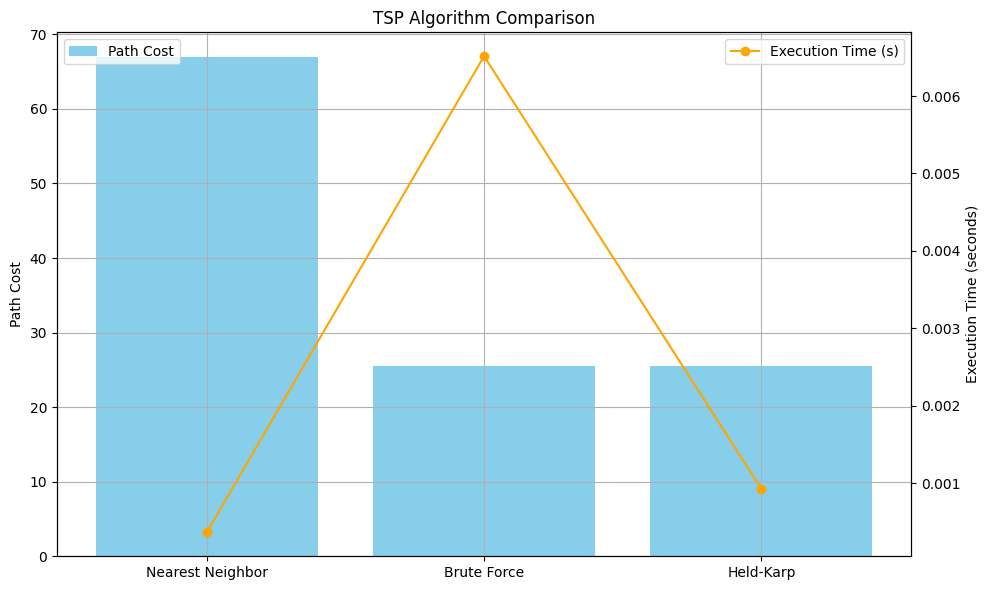

In [52]:
# Step 8: Compare Algorithms
results = [
    {"name": "Nearest Neighbor", "cost": cost_nn, "time": elapsed_nn},
    {"name": "Brute Force", "cost": cost_bf, "time": elapsed_bf},
    {"name": "Held-Karp", "cost": cost_hk, "time": elapsed_hk}
]
plot_comparison_chart(results)